In [1]:
import rpy2.rinterface
%load_ext rpy2.ipython
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor

##In Python
##Read in the data
os.chdir("/Users/Molly/Documents/Math372/")
hitters = pd.read_csv('hitters.csv')
n = len(hitters['Salary'])
##a
expVars = hitters.drop(labels = "Salary", axis = 1)
expVars = "+".join(expVars.columns)

y, X = dmatrices('Salary ~' + expVars, hitters, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["variable"] = X.columns
vif

,VIF Factor,variable
0,21.762082,Intercept
1,4.134115,League[T.N]
2,1.075398,Division[T.W]
3,4.099063,NewLeague[T.N]
4,22.944366,AtBat
5,30.281255,Hits
6,7.758668,HmRun
7,15.246418,Runs
8,11.921715,RBI
9,4.148712,Walks


In [2]:
%%R
##In R
##Read in data and load libraries
library(MASS)
#library(ISLR)
#library(boot)
library(car)
setwd("/Users/Molly/Documents/Math372/")
hitters <- read.csv(file = "hitters.csv", header = T)
n <- dim(hitters)[1]

##a
mod <- lm('Salary ~ .', data = hitters)
vif(mod)

/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: carData

  warnings.warn(x, RRuntimeWarning)


     AtBat       Hits      HmRun       Runs        RBI      Walks      Years 
 22.944366  30.281255   7.758668  15.246418  11.921715   4.148712   9.313280 
    CAtBat      CHits     CHmRun      CRuns       CRBI     CWalks     League 
251.561160 502.954289  46.488462 162.520810 131.965858  19.744105   4.134115 
  Division    PutOuts    Assists     Errors  NewLeague 
  1.075398   1.236317   2.709341   2.214543   4.099063 


Multicollinearity does appear to be an issue. We typically point out variables with VIF >5 or so, and there are several variables in this data set with larger VIF than 5 or even 10. The three variables with the largest VIFs are Career Hits ($CHits = 502.954$), Career At Bats ($CAtBat = 251.56116$), and Career Runs ($CRuns = 162.5208$). It's not really surprising that these are all very high, because they are likely dependent upon one another. A player can't have a lot of hits if he doesn't have very many at bats, and hits mean the player gets on base, which increases the chances that he will score.

In [3]:
%%R
##b
library(leaps)
all_poss <- regsubsets(Salary ~ ., data = hitters, nvmax = 19)
all_poss_summ <- summary(all_poss)
all_poss_summ

Subset selection object
Call: regsubsets.formula(Salary ~ ., data = hitters, nvmax = 19)
19 Variables  (and intercept)
           Forced in Forced out
AtBat          FALSE      FALSE
Hits           FALSE      FALSE
HmRun          FALSE      FALSE
Runs           FALSE      FALSE
RBI            FALSE      FALSE
Walks          FALSE      FALSE
Years          FALSE      FALSE
CAtBat         FALSE      FALSE
CHits          FALSE      FALSE
CHmRun         FALSE      FALSE
CRuns          FALSE      FALSE
CRBI           FALSE      FALSE
CWalks         FALSE      FALSE
LeagueN        FALSE      FALSE
DivisionW      FALSE      FALSE
PutOuts        FALSE      FALSE
Assists        FALSE      FALSE
Errors         FALSE      FALSE
NewLeagueN     FALSE      FALSE
1 subsets of each size up to 19
Selection Algorithm: exhaustive
          AtBat Hits HmRun Runs RBI Walks Years CAtBat CHits CHmRun CRuns CRBI
1  ( 1 )  " "   " "  " "   " "  " " " "   " "   " "    " "   " "    " "   "*" 
2  ( 1 )  " "   "*"

In [4]:
%%R
max_idx <- which.max(all_poss_summ$adjr2)
max_idx

[1] 11


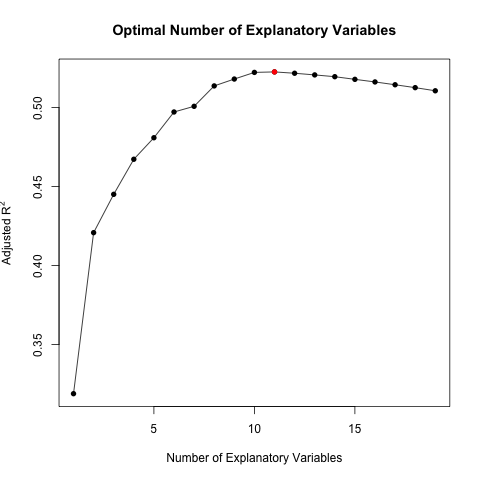

In [5]:
%%R
plot(all_poss_summ$adjr2, type = "l", xlab = "Number of Explanatory Variables", ylab = bquote("Adjusted R"^2), main = "Optimal Number of Explanatory Variables")
points(all_poss_summ$adjr2, pch = 16)
points(x = max_idx, y = all_poss_summ$adjr2[max_idx], pch = 16, col = "red")

In [6]:
%%R
##This tells us we want 11 variables in the model.. so which are they?
all_poss_summ$which[max_idx,]

(Intercept)       AtBat        Hits       HmRun        Runs         RBI 
       TRUE        TRUE        TRUE       FALSE       FALSE       FALSE 
      Walks       Years      CAtBat       CHits      CHmRun       CRuns 
       TRUE       FALSE        TRUE       FALSE       FALSE        TRUE 
       CRBI      CWalks     LeagueN   DivisionW     PutOuts     Assists 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
     Errors  NewLeagueN 
      FALSE       FALSE 


We see here that using 11 explanatory variables gives us the optimal model for this data set. We will want to use the variables AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWalks, League, Division, PutOuts, and Assists.

For each possible number of explanatory variables (in this case, for 0 explanatory variables up to all 19), All Possible Regressions fits every possible model (determined by the unique combinations of $x_i$'s) and decides which new variable in each number category (as the number increases) is the most significant and therefore most important to include in the model for that specific number of variables. For all of these models, R stores the selection criteria BIC, $R_{adj}^2$, and $C_p$ (which we haven't talked about but is in the book). Then, the user picks one of those and selects the optimal number of variables according to that selection criterion. For example, in what I did above, I used $R_{adj}^2$ and had R tell me what number of variables had the highest $R_{adj}^2$ and which of those variables gave me that $R_{adj}^2$.

In [7]:
%%R
##c
library(MASS)
smallest <- lm(Salary ~ 1, data = hitters)
largest <- lm(Salary ~ ., data = hitters)

# Forward Selection
stepAIC(object = smallest, scope = list(upper = largest, lower = smallest), direction = "forward")
mod_forward <- stepAIC(object = smallest, scope = list(upper = largest, lower = smallest), direction = "forward", trace = 0)

Start:  AIC=3215.77
Salary ~ 1

            Df Sum of Sq      RSS    AIC
+ CRBI       1  17139434 36179679 3115.8
+ CRuns      1  16881162 36437951 3117.6
+ CHits      1  16065140 37253973 3123.5
+ CAtBat     1  14759710 38559403 3132.5
+ CHmRun     1  14692193 38626920 3133.0
+ CWalks     1  12792622 40526491 3145.6
+ RBI        1  10771083 42548030 3158.4
+ Walks      1  10504833 42814280 3160.1
+ Hits       1  10260491 43058621 3161.6
+ Runs       1   9399158 43919955 3166.8
+ Years      1   8559105 44760007 3171.7
+ AtBat      1   8309469 45009644 3173.2
+ HmRun      1   6273967 47045145 3184.8
+ PutOuts    1   4814100 48505013 3192.9
+ Division   1   1976102 51343011 3207.8
<none>                   53319113 3215.8
+ Assists    1     34497 53284615 3217.6
+ League     1     10876 53308237 3217.7
+ Errors     1      1555 53317558 3217.8
+ NewLeague  1       428 53318684 3217.8

Step:  AIC=3115.78
Salary ~ CRBI

            Df Sum of Sq      RSS    AIC
+ Hits       1   5533119 306465

In [8]:
%%R
summary(mod_forward)


Call:
lm(formula = Salary ~ CRBI + Hits + PutOuts + Division + AtBat + 
    Walks + CWalks + CRuns + CAtBat + Assists, data = hitters)

Residuals:
    Min      1Q  Median      3Q     Max 
-939.11 -176.87  -34.08  130.90 1910.55 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  162.53544   66.90784   2.429 0.015830 *  
CRBI           0.77431    0.20961   3.694 0.000271 ***
Hits           6.91802    1.64665   4.201 3.69e-05 ***
PutOuts        0.29737    0.07444   3.995 8.50e-05 ***
DivisionW   -112.38006   39.21438  -2.866 0.004511 ** 
AtBat         -2.16865    0.53630  -4.044 7.00e-05 ***
Walks          5.77322    1.58483   3.643 0.000327 ***
CWalks        -0.83083    0.26359  -3.152 0.001818 ** 
CRuns          1.40825    0.39040   3.607 0.000373 ***
CAtBat        -0.13008    0.05550  -2.344 0.019858 *  
Assists        0.28317    0.15766   1.796 0.073673 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 31

Using forward selection, R identified the best model as the one with the 10 variables AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWalks, PutOuts, Assists, and Division.

Forward selection begins by fitting the smallest model possible-- the one with no variables (intercept only). Calculate its AIC. Then, we calculate the AIC for each of the 1 variable models; if the AIC for a 1 variable model is smaller than that of the intercept only model, then we add the 1 variable model with the smallerst AIC. Otherwise, we stick with the current intercept only model. Next, we consider the 2 variable models that have our first chosen variable as one of the two. If the AIC would improve by adding another variable to the model (as indicated by a smaller AIC), then we add the variable that shrinks the AIC the most. Otherwise, we stick with the 1 variable model. This continues until we reach a point where either a) there are no variables we could add that would improve/reduce the AIC or b) we have added all variables to the model. 

So in this specific case, we started with an AIC of 3215.77 and first added CRBI (which reduced the AIC to 3115.8), then Hits (reducing AIC to 3074.1), then PutOuts, etc. up until after we added Assists, which is when the AIC reached a value (3031.26) that would not be reduced upon adding any of the remaining variables.

In [9]:
%%R
#d
# Backward elimination
stepAIC(object = largest, scope = list(upper = largest, lower = smallest), direction = "backward")
mod_backward <- stepAIC(object = largest, scope = list(upper = largest, lower = smallest), direction = "backward", trace = 0)

Start:  AIC=3046.02
Salary ~ AtBat + Hits + HmRun + Runs + RBI + Walks + Years + 
    CAtBat + CHits + CHmRun + CRuns + CRBI + CWalks + League + 
    Division + PutOuts + Assists + Errors + NewLeague

            Df Sum of Sq      RSS    AIC
- CHmRun     1      1138 24201837 3044.0
- CHits      1      3930 24204629 3044.1
- Years      1      7869 24208569 3044.1
- NewLeague  1      9784 24210484 3044.1
- RBI        1     16076 24216776 3044.2
- HmRun      1     48572 24249272 3044.6
- Errors     1     58324 24259023 3044.7
- League     1     62121 24262821 3044.7
- Runs       1     63291 24263990 3044.7
- CRBI       1    135439 24336138 3045.5
- CAtBat     1    159864 24360564 3045.8
<none>                   24200700 3046.0
- Assists    1    280263 24480963 3047.1
- CRuns      1    374007 24574707 3048.1
- CWalks     1    609408 24810108 3050.6
- Division   1    834491 25035190 3052.9
- AtBat      1    971288 25171987 3054.4
- Hits       1    991242 25191941 3054.6
- Walks      1   115

In [10]:
%%R
summary(mod_backward)


Call:
lm(formula = Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + 
    CRBI + CWalks + Division + PutOuts + Assists, data = hitters)

Residuals:
    Min      1Q  Median      3Q     Max 
-939.11 -176.87  -34.08  130.90 1910.55 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  162.53544   66.90784   2.429 0.015830 *  
AtBat         -2.16865    0.53630  -4.044 7.00e-05 ***
Hits           6.91802    1.64665   4.201 3.69e-05 ***
Walks          5.77322    1.58483   3.643 0.000327 ***
CAtBat        -0.13008    0.05550  -2.344 0.019858 *  
CRuns          1.40825    0.39040   3.607 0.000373 ***
CRBI           0.77431    0.20961   3.694 0.000271 ***
CWalks        -0.83083    0.26359  -3.152 0.001818 ** 
DivisionW   -112.38006   39.21438  -2.866 0.004511 ** 
PutOuts        0.29737    0.07444   3.995 8.50e-05 ***
Assists        0.28317    0.15766   1.796 0.073673 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 31

With backward elimination, the model with the 10 variables AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWalks, PutOuts, Assists, and Division was also deemed the best model.

In backward elimination, we begin by fitting the largest model possible-- the full model. Calculate its AIC. Then, we calculate the AIC for each of the $n-1 = 18$ variable models; if the AIC for an 18 variable model is smaller than that of the full model, then we take the 18 variable model without the variable that, upon removal, lowers the AIC the most. Otherwise, we stick with the current full model. Next, we consider the $n-2 = 17$ variable models that have our first chosen variable as one of the two. If the AIC would decrease by dropping another variable to the model, then we drop the variable that shrinks the AIC the most. Otherwise, we stick with the 18 variable model. This continues until we reach a model where either a) there are no variables we could remove that would improve/reduce the AIC or b) we have eliminated all variables from the model. 

So in this specific case, we started with an AIC of 3046.02 and first dropped CHmRun (which reduced the AIC to 3044.03), then dropped Years (reducing AIC to 3042.1), then New League, etc. up until after we eliminated League, which is when the AIC reached a value (3031.26) that would not be reduced upon getting rid any of the remaining variables.

In [11]:
%%R
#e
# Hybrid
stepAIC(object = smallest, scope = list(upper = largest, lower = smallest), direction = "both")
mod_hybrid <- stepAIC(object = smallest, scope = list(upper = largest, lower = smallest), direction = "both", trace = 0)

Start:  AIC=3215.77
Salary ~ 1

            Df Sum of Sq      RSS    AIC
+ CRBI       1  17139434 36179679 3115.8
+ CRuns      1  16881162 36437951 3117.6
+ CHits      1  16065140 37253973 3123.5
+ CAtBat     1  14759710 38559403 3132.5
+ CHmRun     1  14692193 38626920 3133.0
+ CWalks     1  12792622 40526491 3145.6
+ RBI        1  10771083 42548030 3158.4
+ Walks      1  10504833 42814280 3160.1
+ Hits       1  10260491 43058621 3161.6
+ Runs       1   9399158 43919955 3166.8
+ Years      1   8559105 44760007 3171.7
+ AtBat      1   8309469 45009644 3173.2
+ HmRun      1   6273967 47045145 3184.8
+ PutOuts    1   4814100 48505013 3192.9
+ Division   1   1976102 51343011 3207.8
<none>                   53319113 3215.8
+ Assists    1     34497 53284615 3217.6
+ League     1     10876 53308237 3217.7
+ Errors     1      1555 53317558 3217.8
+ NewLeague  1       428 53318684 3217.8

Step:  AIC=3115.78
Salary ~ CRBI

            Df Sum of Sq      RSS    AIC
+ Hits       1   5533119 306465

In [12]:
%%R
summary(mod_hybrid)


Call:
lm(formula = Salary ~ CRBI + Hits + PutOuts + Division + AtBat + 
    Walks + CWalks + CRuns + CAtBat + Assists, data = hitters)

Residuals:
    Min      1Q  Median      3Q     Max 
-939.11 -176.87  -34.08  130.90 1910.55 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  162.53544   66.90784   2.429 0.015830 *  
CRBI           0.77431    0.20961   3.694 0.000271 ***
Hits           6.91802    1.64665   4.201 3.69e-05 ***
PutOuts        0.29737    0.07444   3.995 8.50e-05 ***
DivisionW   -112.38006   39.21438  -2.866 0.004511 ** 
AtBat         -2.16865    0.53630  -4.044 7.00e-05 ***
Walks          5.77322    1.58483   3.643 0.000327 ***
CWalks        -0.83083    0.26359  -3.152 0.001818 ** 
CRuns          1.40825    0.39040   3.607 0.000373 ***
CAtBat        -0.13008    0.05550  -2.344 0.019858 *  
Assists        0.28317    0.15766   1.796 0.073673 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 31

As with the previous two stepwise selection techniques, hybrid selection decided the model with the 10 variables AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWalks, PutOuts, Assists, and Division was the best.

Hybrid selection begins as Forward Selection does-- by fitting the intercept only model, calculating the AIC, and considering all 1 variable models. If the AIC for a 1 variable model is smaller than that of the intercept only model, then we take the 1 variable model with the variable for which the AIC will be the smallest. Otherwise, we stick with the intercept only model. Next, we consider all 2 variable models that have our first chosen variable as one of the two. If the AIC would improve by adding another variable to the model (as indicated by a smaller AIC), then we add the variable that shrinks the AIC the most. Otherwise, we stick with the 1 variable model. (R also considers dropping the first variable, which is redundant, as if this would lower AIC, we would not have added the variable in the first place.) Then, we consider all 3 variable models with the first two chosen variables and an additional one. If the AIC would decrease with another variable added, then we take that three variable model with the smallest AIC. At this step and for the remaining steps, R considers the AICs for all models with one additional variable and one fewer variable (taking all combinations). This allows for the possibility of getting rid of a variable that would be important if we were going to stick to a fixed, small-variable model but may not be important as other variable interactions are added to the model. This continues until we reach a point where  there are no variables we could add or drop that would improve/reduce the AIC.

So in this specific case, we again started with an AIC of 3215.77 and first added CRBI (which reduced the AIC to 3115.8), then Hits (reducing AIC to 3074.1), then PutOuts, etc. up until after we added Assists, which is when the AIC reached a value (3031.26) that would not be reduced upon adding any of the remaining variables. Note that in this selection, we did not ever need to eliminate a variable, but at each step, R did consider what the resulting AIC would be if one of the current variables was dropped (this is indicated by the - sign in the stepAIC table printout).

In [13]:
##f
y = hitters['Salary']
X = hitters.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1)
league = pd.get_dummies(hitters['League'])
division = pd.get_dummies(hitters['Division'])
new_league = pd.get_dummies(hitters['NewLeague'])
X = pd.concat([X, league['A'], division['E'], new_league['A']], axis = 1)
X.columns = ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League', 'Division', 'NewLeague']

## Cross Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
train = pd.concat([X_train, y_train], axis = 1)

mod_full = smf.ols('Salary ~ AtBat + Hits + HmRun + Runs + RBI + Walks + Years + CAtBat + CHits + CHmRun + CRuns + CRBI + CWalks + PutOuts + Assists + Errors + League + Division + NewLeague', data = train).fit()
pred_full = mod_full.predict(X_test)
RMSE1_full = np.sqrt(np.mean((y_test - pred_full)**2))
RMSE1_full

297.3892792917757

In [14]:
m_optim = smf.ols('Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts + Assists + League + Division', data = train).fit()
pred_optim = m_optim.predict(X_test)
RMSE2_optim = np.sqrt(np.mean((y_test - pred_optim)**2))
RMSE2_optim

263.22559728701634

In [15]:
m_best_step = smf.ols('Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts + Assists + Division', data = train).fit()
pred_best_step = m_best_step.predict(X_test)
RMSE_best_step = np.sqrt(np.mean((y_test - pred_best_step)**2))
RMSE_best_step

261.2086780348063

***Note here that I did not need to find the BIC myself. Prof. Stevens told us what those variables were, but my calculations are confirmation, I guess :)

In [16]:
%%R
##We must use R with the bic on all poss summ
##we want to minimize the -logL
min_idxBIC <- which.min(all_poss_summ$bic)
min_idxBIC

[1] 6


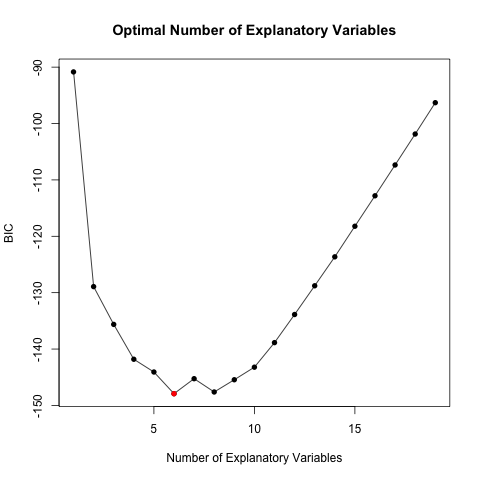

In [17]:
%%R
plot(all_poss_summ$bic, type = "l", xlab = "Number of Explanatory Variables", ylab = bquote("BIC"), main = "Optimal Number of Explanatory Variables")
points(all_poss_summ$bic, pch = 16)
points(x = min_idxBIC, y = all_poss_summ$bic[min_idxBIC], pch = 16, col = "red")

In [18]:
%%R
##This tells us we want the following 6 variables in the model
all_poss_summ$which[min_idxBIC,]

(Intercept)       AtBat        Hits       HmRun        Runs         RBI 
       TRUE        TRUE        TRUE       FALSE       FALSE       FALSE 
      Walks       Years      CAtBat       CHits      CHmRun       CRuns 
       TRUE       FALSE       FALSE       FALSE       FALSE       FALSE 
       CRBI      CWalks     LeagueN   DivisionW     PutOuts     Assists 
       TRUE       FALSE       FALSE        TRUE        TRUE       FALSE 
     Errors  NewLeagueN 
      FALSE       FALSE 


It looks like AtBat, Hits, Walks, CRBI, Division, and PutOuts are the variables we should have in the model.

In [19]:
### 
m_best_BIC = smf.ols('Salary ~ AtBat + Hits + Walks + CRBI + PutOuts + Division', data = train).fit()
pred_best_BIC = m_best_BIC.predict(X_test)
RMSE3_best_BIC = np.sqrt(np.mean((y_test - pred_best_BIC)**2))
RMSE3_best_BIC

260.2940168201846

In [20]:
%%R
##part f
library(ISLR)
trn <- sample(x = c(rep(TRUE, round(0.8 * n)), rep(FALSE, n-round(0.8*n))), size = n, replace = FALSE)
train <- hitters[trn,]
tst <- !trn 
test <- hitters[tst,]

mFull <- lm(Salary ~ ., data = train)
predFull <- predict(object = mFull, newdata = test)
RMSEFull <- sqrt(mean((test$Salary - predFull)^2))
RMSEFull

[1] 305.7212


In [21]:
%%R

mOptim <- lm(Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts + Assists + Division + League, data = train)
predOptim <- predict(object = mOptim, newdata = test)
RMSEOptim <- sqrt(mean((test$Salary - predOptim)^2))
RMSEOptim

[1] 297.2808


In [22]:
%%R

mStep <- lm(Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts + Assists + Division, data = train)
predStep <- predict(object = mStep, newdata = test)
RMSEStep <- sqrt(mean((test$Salary - predStep)^2))
RMSEStep

[1] 299.5452


In [23]:
%%R

mBIC <- lm(Salary ~ AtBat + Hits + Walks + CRBI + PutOuts + Division, data = train)
predBIC <- predict(object = mBIC, newdata = test)
RMSEBIC <- sqrt(mean((test$Salary - predBIC)^2))
RMSEBIC

[1] 296.8516


It's honestly really hard to tell which is the best using plain cross validation. The full model is always the worst, but the other three seem to take turns having the lowest RMSE. The values fluctuate pretty wildly with different random sets of train and test (from 210 ish to 400 some), and there is not one model that consistently has the lowest RMSE.

In [24]:
#g
## K-fold Cross Validation
#full
numfolds = 10
kf = KFold(n_splits=numfolds, shuffle = True)
MSE = 0
for train_indices, test_indices in kf.split(X):
    train_X = X.iloc[train_indices, :]; train_y = y[train_indices]
    test_X = X.iloc[test_indices, :]; test_y = y[test_indices]
    training = pd.concat([train_X, train_y], axis = 1)
    m = smf.ols('Salary ~ AtBat + Hits + HmRun + Runs + RBI + Walks + Years + CAtBat + CHits + CHmRun + CRuns + CRBI + CWalks + PutOuts + Assists + Errors + League + Division + NewLeague', data = training).fit()   
    pred = m.predict(test_X)
    MSE = MSE + np.mean((test_y - pred)**2)
RMSE1 = np.sqrt(MSE/numfolds)
RMSE1

346.9856367760651

In [25]:
#optim
numfolds = 10
kf = KFold(n_splits=numfolds, shuffle = True)
MSE = 0
for train_indices, test_indices in kf.split(X):
    train_X = X.iloc[train_indices, :]; train_y = y[train_indices]
    test_X = X.iloc[test_indices, :]; test_y = y[test_indices]
    training = pd.concat([train_X, train_y], axis = 1)
    m = smf.ols('Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts + Assists + Division + League', data = training).fit()   
    pred = m.predict(test_X)
    MSE = MSE + np.mean((test_y - pred)**2)
RMSE2 = np.sqrt(MSE/numfolds)
RMSE2

329.01199556924666

In [26]:
#step
numfolds = 10
kf = KFold(n_splits=numfolds, shuffle = True)
MSE = 0
for train_indices, test_indices in kf.split(X):
    train_X = X.ix[train_indices, :]; train_y = y[train_indices]
    test_X = X.ix[test_indices, :]; test_y = y[test_indices]
    training = pd.concat([train_X, train_y], axis = 1)
    m = smf.ols('Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts + Assists + Division', data = training).fit()   
    pred = m.predict(test_X)
    MSE = MSE + np.mean((test_y - pred)**2)
RMSE3 = np.sqrt(MSE/numfolds)
RMSE3

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


325.1109143901445

In [27]:
#bic
numfolds = 10
kf = KFold(n_splits=numfolds, shuffle = True)
MSE = 0
for train_indices, test_indices in kf.split(X):
    train_X = X.ix[train_indices, :]; train_y = y[train_indices]
    test_X = X.ix[test_indices, :]; test_y = y[test_indices]
    training = pd.concat([train_X, train_y], axis = 1)
    m = smf.ols('Salary ~ AtBat + Hits + Walks + CRBI + PutOuts + Division', data = training).fit()   
    pred = m.predict(test_X)
    MSE = MSE + np.mean((test_y - pred)**2)
RMSE4 = np.sqrt(MSE/numfolds)
RMSE4

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


327.1714421758377

In [28]:
%%R

#g
## K-fold Cross-Validation
#full
library(boot)
m1 <- glm(Salary ~ ., data = hitters)
RMSE1 <- sqrt((cv.glm(hitters, m1, K = 10)$delta)[1])
RMSE1

/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘boot’


  warnings.warn(x, RRuntimeWarning)
/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following object is masked from ‘package:car’:

    logit


  warnings.warn(x, RRuntimeWarning)


[1] 340.0029


In [29]:
%%R
#optim
m2 <- glm(Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts + Assists + Division + League, data = hitters)
RMSE2 <- sqrt((cv.glm(hitters, m2, K = 10)$delta)[1])
RMSE2

[1] 331.6135


In [30]:
%%R
#step
m3 <- glm(Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts + Assists + Division, data = hitters)
RMSE3 <- sqrt((cv.glm(hitters, m3, K = 10)$delta)[1])
RMSE3

[1] 328.6117


In [31]:
%%R
#bic
m4 <- glm(Salary ~ AtBat + Hits + Walks + CRBI + PutOuts + Division, data = hitters)
RMSE4 <- sqrt((cv.glm(hitters, m4, K = 10)$delta)[1])
RMSE4

[1] 331.8784


Stepwise Selection Model appears to be the best. The K-Fold Validation method shows the Stepwise RMSE as about 0.5 (for an average random generation of training/test sets) less than that of the Optimal model. Since RMSE is a measure of how close the observed values are to the model's predicted values, a low RMSE indicates the model will have a good predictive accuracy.

h)

K-Fold Validation is much more reliable than Cross Validation (due to the potentially large variability of the latter), and it actually gives us consistent evidence that Stepwise Selection Model is the best choice for us to use. The K-fold validation estimates of RMSE are more stable since we take multiple measurements of the MSE and average them, so we can trust K-fold more and believe they more accurately depict the predictive accuracy of the model.

i)

I would probably want to use the Stepwise Selection Model if I were going for predictive accuracy. Even though SS Model has fewer variables than Optim Model, the one additional variable in Optim (League) must not be important enough to actually make a difference in the predictive accuracy. Also, the Stepwise Selection process showed that adding League to the model would raise the AIC; AIC quantifies the goodness of fit of the model while penalizing unneeded complexity, so the lower AIC of the SS Model (without League) as compared to the higher AIC of the model with League (Optim) tells us that adding League is more of a burden than a help in terms of simplicity and calculations.